In [1]:
#import packages
from __future__ import print_function
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf

In [2]:
#load the file
filepath = "student_vectors_n_task_10_n_limit_10000.json"
student_vectors = json.load(open(filepath))

In [3]:
# Preparing a mapping from qual_id and ccssm to one hot representation

# collect all qual_ids, ccssm_labels, task_ids in separate lists
all_qual_ids = []
all_ccssm_labels = []
all_task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        all_qual_ids.append(j['qual_id'])
        all_ccssm_labels.append(j['ccssm'])
        all_task_ids.append(j['task_id'])

# make a set of unique values from the above lists
unique_ids = set(all_qual_ids)
unique_labels = set(all_ccssm_labels)
unique_tasks = set(all_task_ids)
# print("Number of unique labels in this dataset " + str(len(unique_labels))) #unique labels
# print("Number of unique lessons/tasks in this dataset "+str(len(unique_tasks))) #unique lessons
# print("Number of unique questions in this dataset "+str(len(unique_ids))) #this is the length of bit vector (number of unique qual_ids)

# generate vectors to give to fit_transform in multilabelbinarizer to further generate unique 1-hot encoding
transform_ids = []
for i in unique_ids:
    transform_ids.append([i])

transform_labels = []
for i in unique_labels:
    transform_labels.append([i])
    
# generate dictionary that maps labels and qual_ids to their respective 1-hot encoding
enc = MultiLabelBinarizer()
qual_ids_1hot = (enc.fit_transform(transform_ids)).astype(float)
qual_ids_classes = enc.classes_
qual_ids_dict = dict(zip(unique_ids, qual_ids_1hot))
labels_1hot = enc.fit_transform(transform_labels).astype(float)
labels_classes = enc.classes_
labels_dict = dict(zip(unique_labels,labels_1hot))

52209


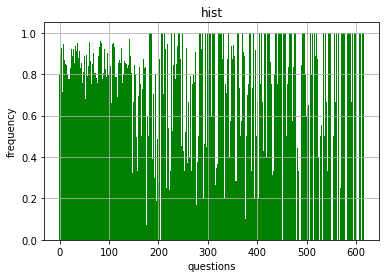

In [4]:
import matplotlib.pyplot as plt
#preparing a mapping from qual_id and ccssm to normalized frequency distribution
freq_dist = {}
total_occ = {}
total_interactions = 0
for i in student_vectors:
    for j in student_vectors[i]:
        total_interactions += 1
        if j['qual_id'] in total_occ:
            total_occ[j['qual_id']] += 1
        else:
            total_occ[j['qual_id']] = 1
        if j['ccssm'] in total_occ:
            total_occ[j['ccssm']] += 1
        else:
            total_occ[j['ccssm']] = 1
        if j['correct'] == True:
            if j['qual_id'] in freq_dist:
                freq_dist[j['qual_id']] += 1
            else:
                freq_dist[j['qual_id']] = 1
            if j['ccssm'] in freq_dist:
                freq_dist[j['ccssm']] += 1
            else:
                freq_dist[j['ccssm']] = 1
        if j['correct'] == False: #what if all occurences were answered incorrectly
            if j['qual_id'] not in freq_dist:
                freq_dist[j['qual_id']] = 0
            if j['ccssm'] not in freq_dist:
                freq_dist[j['ccssm']] = 0
# print(freq_dist)
# print("\n\n\n")
# print(total_occ)
# for i in freq_dist:
#     if freq_dist[i] != total_occ[i]:
#         print(i)
#         print(freq_dist[i])
#         print(total_occ[i])
#         print("\n")
for i in freq_dist:
    freq_dist[i] = float(freq_dist[i]) / float(total_occ[i])
    
print(total_interactions)
N = len(freq_dist)
ind = np.arange(N)
plt.bar(ind, freq_dist.values(), width=1, color='g')
plt.xlabel('questions')
plt.ylabel('frequency')
plt.title("hist")
plt.grid(True)
plt.show()

In [5]:
#construct a vector where we place the frequency of a qual_id/ccssm at the position of the qual_id/ccssm in the vector.
y_vector = np.zeros([len(unique_labels) + len(unique_ids)])
y_vector_qual = np.zeros([len(unique_ids)])
y_vector_ccssm = np.zeros([len(unique_labels)])
for i in student_vectors:
    for j in student_vectors[i]:
        id_pos = np.argmax(qual_ids_dict[j['qual_id']])
        label_pos = np.argmax(labels_dict[j['ccssm']]) + len(unique_ids)
        if(y_vector_qual[id_pos] == 0.0):
            y_vector_qual[id_pos] = freq_dist[j['qual_id']]
        if(y_vector_ccssm[label_pos-len(unique_ids)] == 0.0):
            y_vector_ccssm[label_pos-len(unique_ids)] = freq_dist[j['ccssm']]
        if(y_vector[id_pos] == 0.0):
            y_vector[id_pos] = freq_dist[j['qual_id']]
        if(y_vector[label_pos] == 0.0):
            y_vector[label_pos] = freq_dist[j['ccssm']]

In [6]:
# prepare labels array of size: [total_interactions, len(unique_labels) + len(unique_ids)]
# but total_interactions should not take into account 
# first counting cases with effective interaction
# that too only in the last question of a student's interaction
index = 0
flag = False
for i in student_vectors:
    for j in student_vectors[i]:
        pass
    if(j['correct'] == True):
        #correct in first try
        index += 1
    elif(j['correct'] == False and j['second_try'] == True):
        #false even after second try
        index += 1
print(index)
effective_interactions = index
y_tensor = np.zeros([effective_interactions, len(unique_labels) + len(unique_ids)])
y_tensor_qual = np.zeros([effective_interactions, len(unique_ids)])
y_tensor_ccssm = np.zeros([effective_interactions, len(unique_labels)])

index = 0
flag = False
for i in student_vectors:
    for j in student_vectors[i]:
        pass
    if(j['correct'] == True):
        #correct in first try
        a = qual_ids_dict[j['qual_id']]
        b = labels_dict[j['ccssm']]
        temp = np.append(a, b)
        y_tensor[index] = temp
        y_tensor_qual[index] = a
        y_tensor_ccssm[index] = b
        index += 1
    elif(j['correct'] == False and j['second_try'] == True):
        a = qual_ids_dict[j['qual_id']]
        b = labels_dict[j['ccssm']]
        temp = np.append(a, b)
        #temp = temp * (1.0/3.0)
        temp = temp * (0.0)
        y_tensor[index] = temp
        y_tensor_qual[index] = a * 0.0
        y_tensor_ccssm[index] = b * 0.0
        index += 1

# prepare predictions array of size: [effective_interactions, len(unique_labels) + len(unique_ids)]; 
pred_tensor = np.zeros([effective_interactions, len(unique_labels) + len(unique_ids)])
pred_tensor_qual = np.zeros([effective_interactions, len(unique_ids)])
pred_tensor_ccssm = np.zeros([effective_interactions, len(unique_labels)])
for i in range(effective_interactions):
    pred_tensor[i] = y_vector
    pred_tensor_qual[i] = y_vector_qual
    pred_tensor_ccssm[i] = y_vector_ccssm
    
#process y_tensor for auc
# for i in range(len(y_tensor)):
#     for j in range(len(y_tensor[0])):
#         if(y_tensor[i][j] == 1.0):
#             print(y_tensor[i])

1243


In [7]:
# pred = tf.placeholder(tf.float32, [None, len(unique_labels) + len(unique_ids)])
# y = tf.placeholder(tf.float32, [None, len(unique_labels) + len(unique_ids)])
# if tf.VERSION == '1.3.0':
#     auc, opts = tf.metrics.auc(labels = y, predictions = pred, curve='ROC')
# elif tf.VERSION == '0.12.1': #summit's tensorflow version API doc: https://www.tensorflow.org/versions/r0.12/api_docs/
#     auc, opts = tf.contrib.metrics.streaming_auc(labels = y, predictions = pred, curve='ROC')
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     sess.run(tf.local_variables_initializer()) #https://github.com/tensorflow/tensorflow/issues/3971
#     auc_out,opts_out = sess.run([auc,opts],feed_dict={y: y_tensor, pred: pred_tensor})
#     print(auc_out)
#     print(opts_out)
temp_split = int(np.floor(0.9 * len(y_tensor_ccssm)))
print(temp_split)
y_true_qual = y_tensor_qual[temp_split:]
y_scores_qual = pred_tensor_qual[temp_split:]
y_true_ccssm = y_tensor_ccssm[temp_split:]
y_scores_ccssm = pred_tensor_ccssm[temp_split:]
print(y_true_ccssm.shape)
print(y_scores_ccssm.shape)
print(y_true_qual.shape)
print(y_scores_qual.shape)

1118
(125, 4)
(125, 4)
(125, 612)
(125, 612)


In [10]:
# import numpy as np
# from sklearn.metrics import roc_auc_score
y_true = y_tensor
y_scores = pred_tensor
# print("sklearn auc: {}".format(roc_auc_score(y_true, y_scores)))

import tensorflow as tf
auc_qual, update_op_qual = tf.metrics.auc(y_true_qual, y_scores_qual)
auc_ccssm, update_op_ccssm = tf.metrics.auc(y_true_ccssm, y_scores_ccssm)
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("tf auc qual: {}".format(sess.run([auc_qual, update_op_qual])))
    print("tf auc ccssm: {}".format(sess.run([auc_ccssm, update_op_ccssm])))

tf auc qual: [0.0, 0.56431329]
tf auc ccssm: [0.34564644, 0.62129569]
